In [1]:
import sys
import os

# Get the parent directory of current directory
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(parent_dir)

# Now you can import from pyScripts
from oldmarch.cluster_g_logit_init_acceptpsi import *

%load_ext autoreload


In [2]:

%autoreload 2
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

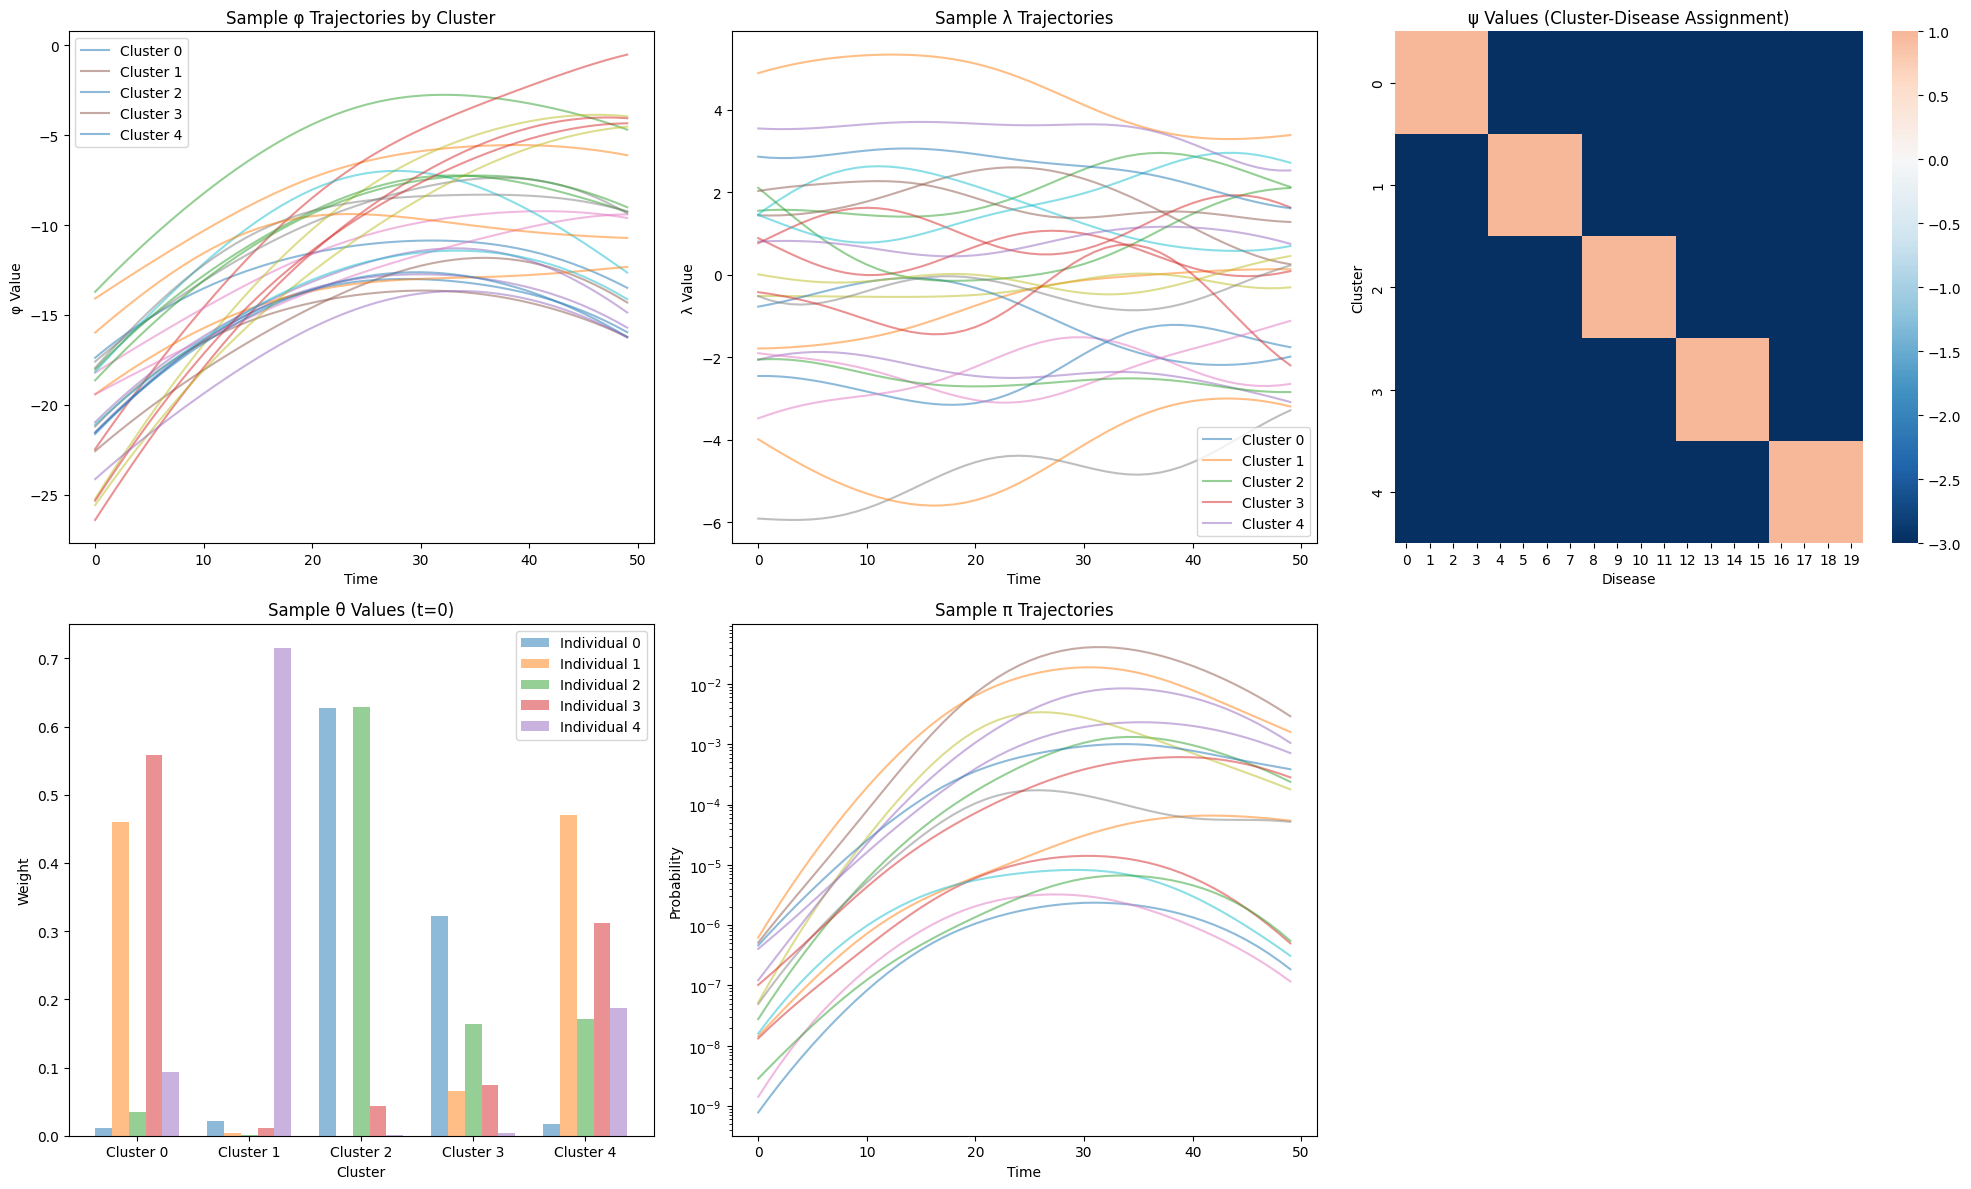

In [3]:
# Generate and plot
np.random.seed(42)
data = generate_clustered_survival_data(N=10000, D=20, T=50, K=5, P=5)
plot_synthetic_components(data)

In [4]:
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
Y_avg = torch.mean(Y_tensor, dim=2)
Y_corr = torch.corrcoef(Y_avg.T)
Y_avg


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0200,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0200,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0200,  ..., 0.0200, 0.0000, 0.0000]])

In [5]:

K=5
similarity = (Y_corr + 1) / 2
spectral = SpectralClustering(
            n_clusters=K,  # One less for background state
            assign_labels='kmeans',
            affinity='precomputed',
            n_init=10,
            random_state=42
        ).fit(similarity.numpy())
        
clusters = spectral.labels_

In [6]:
print("Number of events per disease:")
print(data['Y'].sum(axis=(0,2)))  # Sum over individuals and time
print(data['Y'].mean(axis=(0,2)))  # Sum over individuals and time

print("\nNumber of events per time point:")
print(data['Y'].sum(axis=(0,1)))  # Sum over individuals and diseases

Number of events per disease:
[1.000e+00 1.300e+02 1.355e+03 3.637e+03 2.800e+01 7.646e+03 4.710e+02
 1.000e+04 3.637e+03 6.663e+03 8.242e+03 2.370e+02 9.986e+03 1.247e+03
 8.220e+02 9.059e+03 9.957e+03 9.801e+03 6.000e+00 2.830e+02]
[2.0000e-06 2.6000e-04 2.7100e-03 7.2740e-03 5.6000e-05 1.5292e-02
 9.4200e-04 2.0000e-02 7.2740e-03 1.3326e-02 1.6484e-02 4.7400e-04
 1.9972e-02 2.4940e-03 1.6440e-03 1.8118e-02 1.9914e-02 1.9602e-02
 1.2000e-05 5.6600e-04]

Number of events per time point:
[  12.   22.   27.   57.  103.  145.  236.  303.  413.  486.  540.  611.
  623.  695.  701.  736.  821.  922. 1043. 1090. 1178. 1237. 1245. 1252.
 1235. 1282. 1378. 1541. 1748. 2033. 2208. 2551. 2865. 2939. 3117. 3191.
 3224. 3270. 3361. 3302. 3448. 3398. 3492. 3229. 3095. 3024. 2774. 2574.
 2284. 2147.]


In [7]:
# First generate synthetic data
np.random.seed(42)

# Convert data to tensors for the model
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
G_tensor = torch.tensor(data['G'], dtype=torch.float32)
E_tensor = torch.tensor(data['event_times'], dtype=torch.float32)
true_psi = torch.tensor(data['psi'], dtype=torch.float32)


In [8]:

# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(Y_tensor)  # Average over individuals



In [9]:

from clust_huge_amp_troubleshoot import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_troubleshoot.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_troubleshoot.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_troubleshoot.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 3 diseases
Cluster 1: 8 diseases
Cluster 2: 4 diseases
Cluster 3: 3 diseases
Cluster 4: 2 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 3
Base value (first 5): tensor([ -7.1997, -10.5076, -10.5076, -10.5076,  -7.1997])
Base value centered (first 5): tensor([ 0.6275, -2.6804, -2.6804, -2.6804,  0.6275])
Base value centered mean: 3.0059814548621944e-07
Gamma init for k=0 (first 5): tensor([ 0.2781,  0.2558, -0.2568, -0.2966,  0.1783])

Calculating gamma for k=1:
Number of diseases in cluster: 8
Base value (first 5): tensor([-10.0941, -10.0941, -10.0941, -10.0941, -10.0941])
Base value centered (first 5): tensor([-0.0388, -0.0388, -0.0388, -0.0388, -0.0388])
Base value centered mean: 4.2476654016354587e-07
Gamma init for k=1 (first 5): tensor([ 0.0050, -0.0058,  0.0114,  0.0317, -0.0129])

Calculating gamma for k=2:
Number of diseases in cluster: 4
Base value (first 5): tensor([ -3.8918, -11.3346,  -3.8918,  -6.3727,  -8.8537])
Base value c

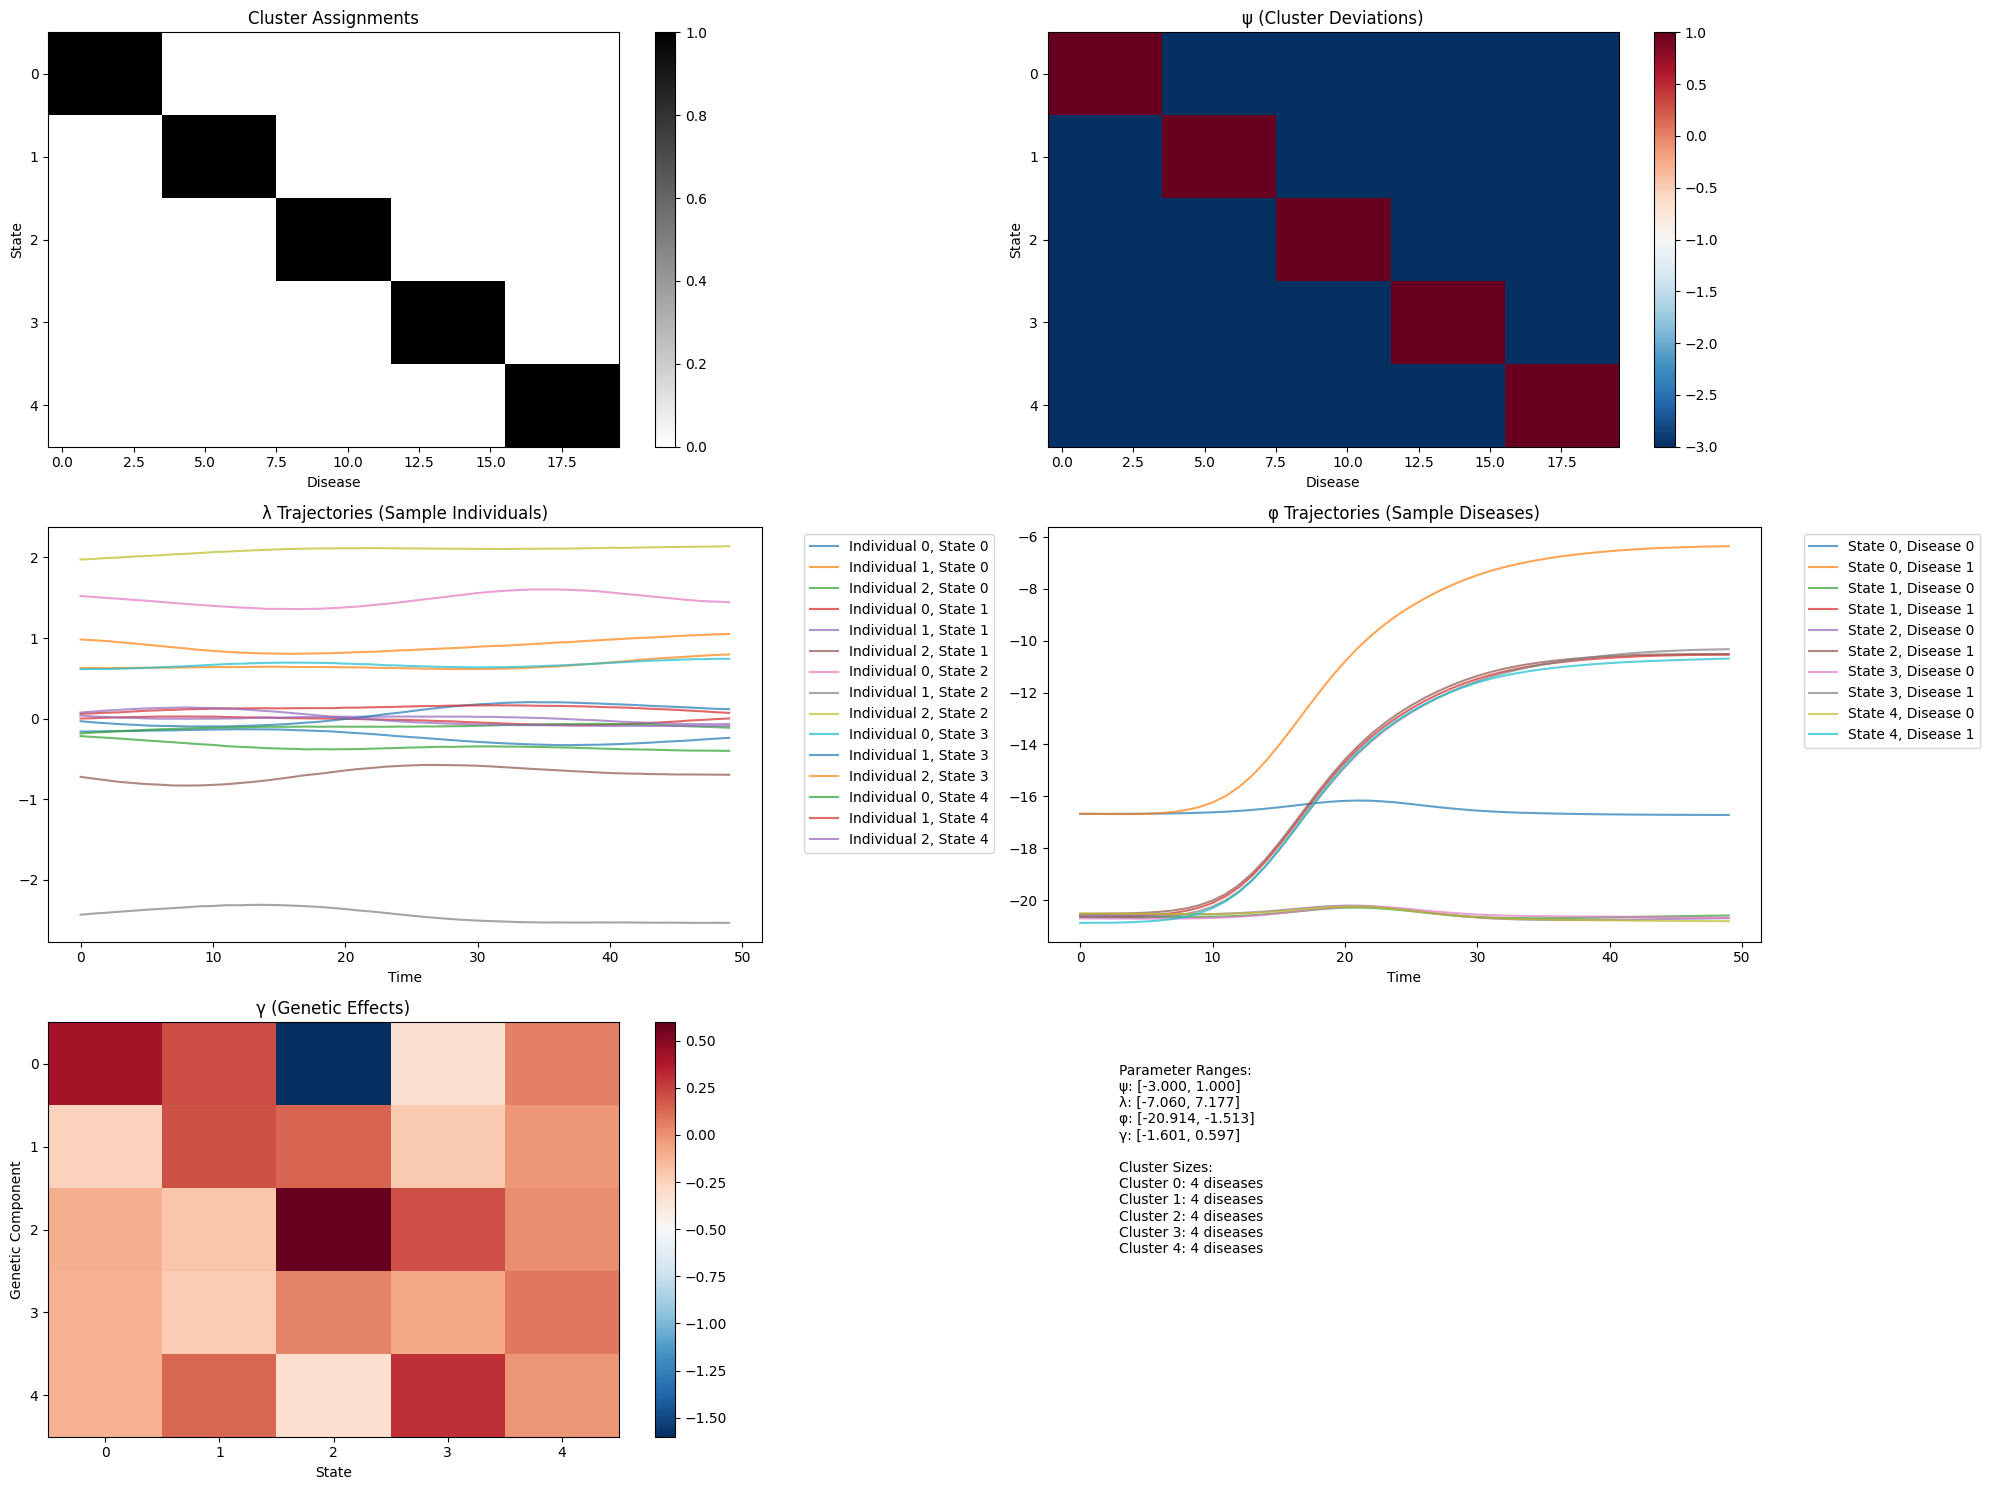

In [10]:
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,
    R=0,                     # Make sure R is provided
    W=1e-4,                # Make sure W is provided
    prevalence_t=prevalence_t,
    init_sd_scaler=1e-1,     # This matches your class definition
    genetic_scale=1,
    signature_references=None,
    healthy_reference=None,
    disease_names=None,
    flat_lambda=True,
    learn_kappa=True
)
# Initialize with true psi
model.initialize_params(true_psi=true_psi)
model.clusters = data['clusters'] 

model.visualize_initialization()

In [11]:

K=5
# Store initial psi values
initial_psi = model.psi.detach().clone()

import cProfile
import pstats
from pstats import SortKey

# For the healthtoo version
profiler = cProfile.Profile()
profiler.enable()
history_new = model.fit(E_tensor, num_epochs=100, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)


Epoch 0

Pre-loss Parameter Stats:
Lambda: mean=-0.0000, std=0.8804
Phi: mean=-12.8289, std=5.8395

Loss Components:
Loss censored: 16600.009765625, is NaN: False
Loss event: 369533.6875, is NaN: False
Loss no event: -0.0, is NaN: False
Total data loss: 38.61336898803711, is NaN: False
Lambda Cholesky decomposition successful
Phi Cholesky decomposition successful

Kernel Statistics:
K_lambda condition number: 45214952.0
K_phi condition number: 104912536.0


/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_troubleshoot.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Final GP loss components:
Lambda GP loss: 112.42475891113281
Phi GP loss: 112.099365234375
GP loss: 224.5241241455078, is NaN: False

Loss before backward: 38.63582229614258
Loss is NaN: False

Gradient Statistics:
Lambda grad: mean=0.0000, std=0.0000
Phi grad: mean=-0.0012, std=0.0074
Lambda grad has NaN: False
Phi grad has NaN: False

Post-update Parameter Stats:
Lambda: mean=-0.0053, std=0.8852
Phi: mean=-12.8281, std=5.8407

Monitoring signature responses:

Disease 14 (signature 3, LR=66.45):
  Theta for diagnosed: 0.230 ± 0.089
  Theta for others: 0.162
  Proportion difference: 0.069

Disease 1 (signature 0, LR=60.25):
  Theta for diagnosed: 0.271 ± 0.114
  Theta for others: 0.197
  Proportion difference: 0.074

Disease 13 (signature 3, LR=58.36):
  Theta for diagnosed: 0.215 ± 0.091
  Theta for others: 0.160
  Proportion difference: 0.055

Disease 16 (signature 4, LR=58.27):
  Theta for diagnosed: 0.167 ± 0.067
  Theta for others: 0.055
  Proportion difference: 0.111

Disease 3 

In [12]:
history_new[0]
    

[38.63582229614258,
 176.13821411132812,
 50.812557220458984,
 69.92330932617188,
 111.55606842041016,
 91.73709106445312,
 54.889869689941406,
 41.474727630615234,
 54.67424774169922,
 69.19413757324219,
 66.26589965820312,
 51.14424514770508,
 39.058494567871094,
 38.67334747314453,
 46.234657287597656,
 51.495361328125,
 48.815330505371094,
 41.28468322753906,
 35.70551300048828,
 35.77769088745117,
 39.432273864746094,
 41.782466888427734,
 40.247432708740234,
 36.47275161743164,
 33.893463134765625,
 34.191383361816406,
 36.02638244628906,
 36.860599517822266,
 35.6634635925293,
 33.637168884277344,
 32.61112594604492,
 33.11404037475586,
 34.06031036376953,
 34.1308479309082,
 33.172210693359375,
 32.14382553100586,
 31.919557571411133,
 32.382198333740234,
 32.7180061340332,
 32.415382385253906,
 31.766210556030273,
 31.39983558654785,
 31.525169372558594,
 31.76951026916504,
 31.702526092529297,
 31.338520050048828,
 31.039926528930664,
 31.033063888549805,
 31.165184020996094,

In [16]:
model.kappa

Parameter containing:
tensor([4.1958], requires_grad=True)

In [20]:
def plot_training_evolution(history_tuple):
    losses, gradient_history = history_tuple
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    #plt.yscale('log')
    plt.legend()
    
    # Plot lambda gradients
    plt.subplot(1, 3, 2)
    lambda_norms = [torch.norm(g).item() for g in gradient_history['lambda_grad']]
    plt.plot(lambda_norms, label='Lambda gradients')
    #plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Lambda Gradient Evolution')
    plt.legend()
    
    # Plot phi gradients
    plt.subplot(1, 3, 3)
    phi_norms = [torch.norm(g).item() for g in gradient_history['phi_grad']]
    plt.plot(phi_norms, label='Phi gradients')
    #plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.title('Phi Gradient Evolution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

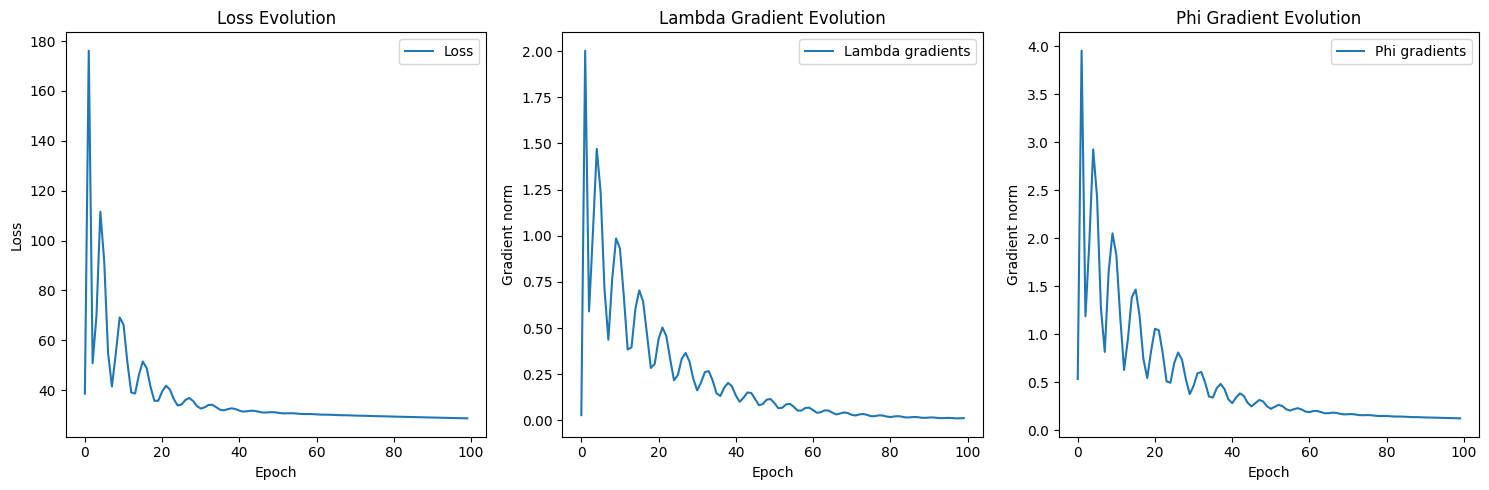

In [19]:
plot_training_evolution(history_new)

In [21]:
lambda_nans = [torch.isnan(g).any().item() for g in history_new[1]['lambda_grad']]
phi_nans = [torch.isnan(g).any().item() for g in history_new[1]['phi_grad']]

In [22]:
initial_psi


tensor([[ 1.,  1.,  1.,  1., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3.,  1.,  1.,  1.,  1., -3., -3., -3., -3., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.,  1.,  1.,  1.,  1., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,  1.,  1.,
          1.,  1., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
         -3., -3.,  1.,  1.,  1.,  1.]])

In [23]:
model.psi

Parameter containing:
tensor([[ 1.0621,  1.0751,  0.8009,  1.4103, -3.0648, -2.9520, -3.0208, -2.9674,
         -3.0257, -3.0445, -3.0684, -3.0090, -3.0914, -2.9968, -2.9928, -3.0935,
         -2.8607, -3.1615, -2.9801, -3.0713],
        [-2.9210, -2.9594, -2.8838, -3.1425,  0.9159,  1.3653,  1.3078,  0.5617,
         -3.1811, -3.1622, -3.1672, -3.0690, -3.1069, -2.8912, -3.0022, -3.0930,
         -3.0180, -3.2782, -2.9798, -3.0447],
        [-2.9274, -2.8918, -3.0591, -3.1193, -3.0934, -2.2691, -2.9651, -2.9410,
          0.3726,  0.9879,  0.9443,  1.1035, -3.2370, -3.0167, -3.0239, -2.8283,
         -3.0579, -3.3736, -2.9893, -3.0189],
        [-2.9575, -2.9287, -2.9540, -2.9958, -3.0398, -2.9226, -2.9469, -3.1654,
         -3.0736, -2.9856, -3.0813, -2.9491, -0.0371,  0.7413,  0.8884,  1.7195,
         -2.9547, -3.1023, -3.0983, -3.0128],
        [-2.9323, -3.0818, -2.9320, -2.9814, -3.0826, -3.0004, -2.9246, -3.1130,
         -3.0464, -3.0977, -3.0066, -3.0392, -3.0305, -3.1357, -3

In [24]:
model.kappa

Parameter containing:
tensor([4.1958], requires_grad=True)

In [25]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = data['Y'].mean(axis=0)  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[:, d].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

In [29]:
with torch.no_grad():
    pi_pred, theta, phi = model.forward()
    pi_pred = pi_pred.cpu().numpy()

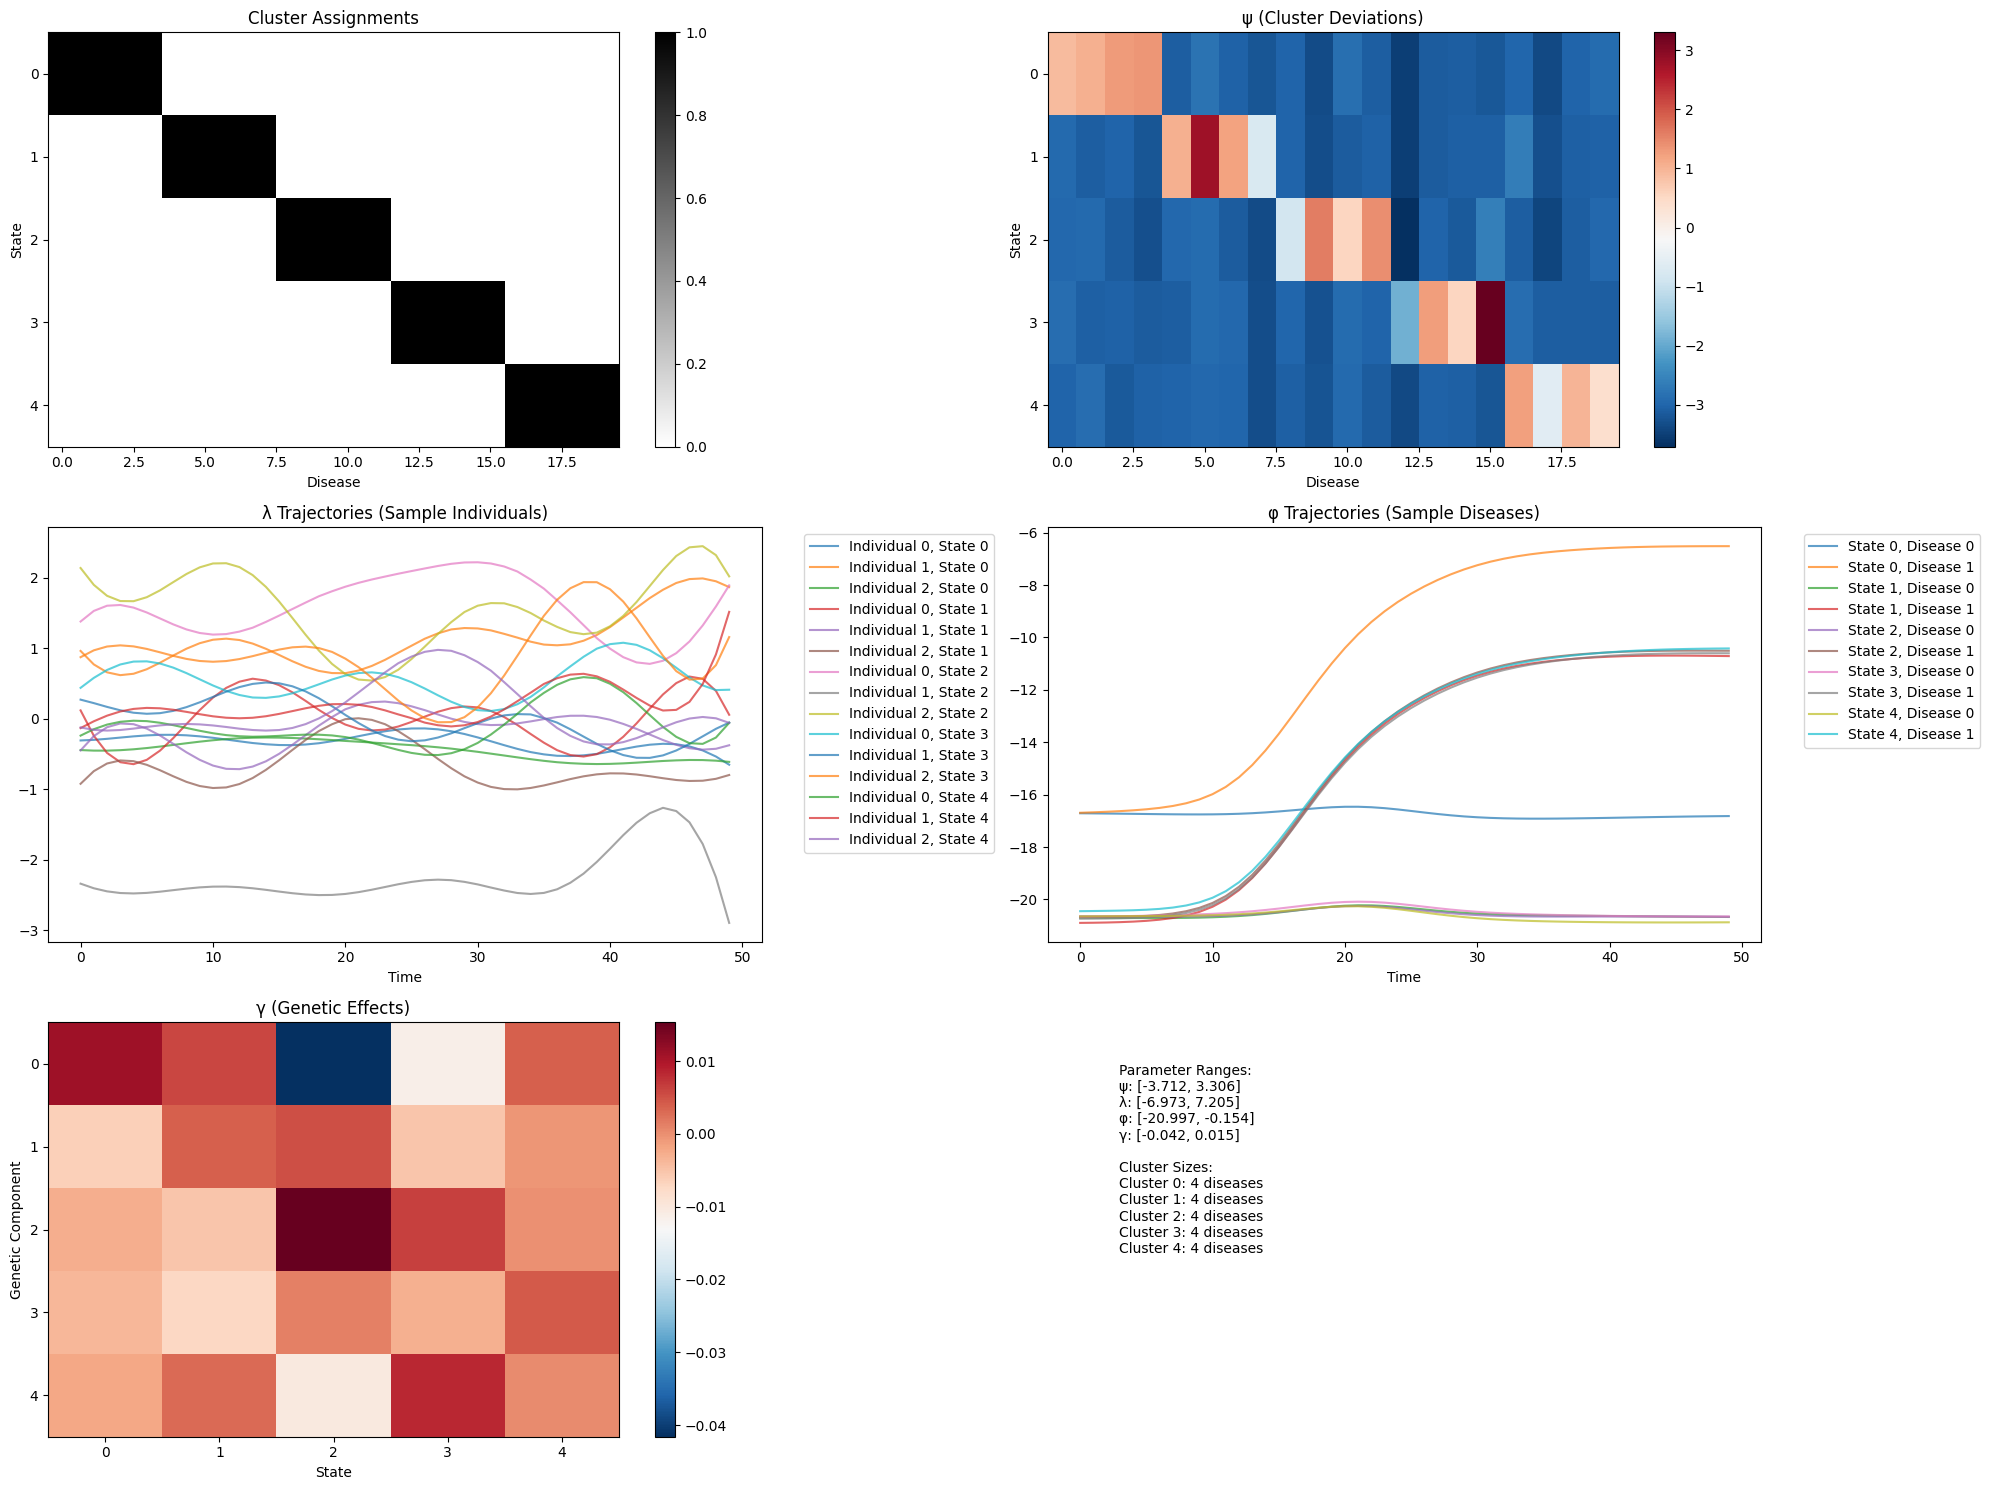

In [22]:
model.visualize_initialization()

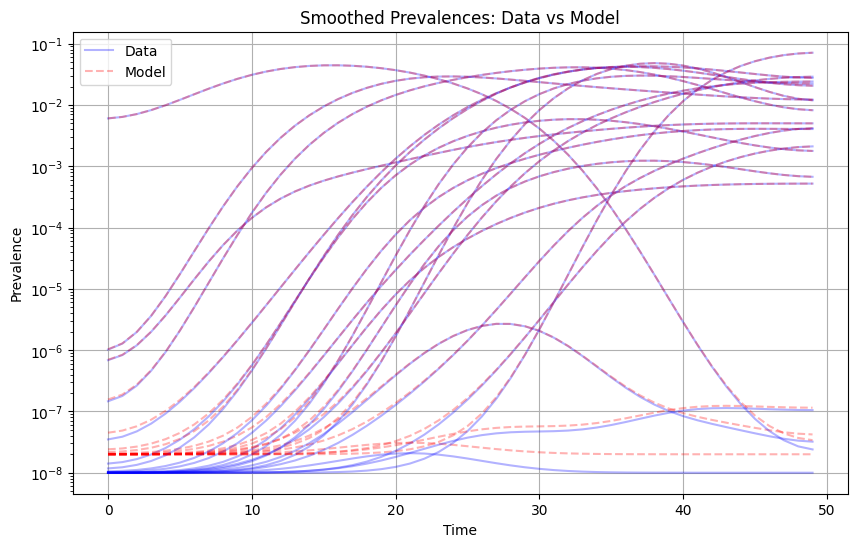

In [26]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = compute_smoothed_prevalence(data['Y'])  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[d, :].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

plot_smoothed_prevalences(model, data)

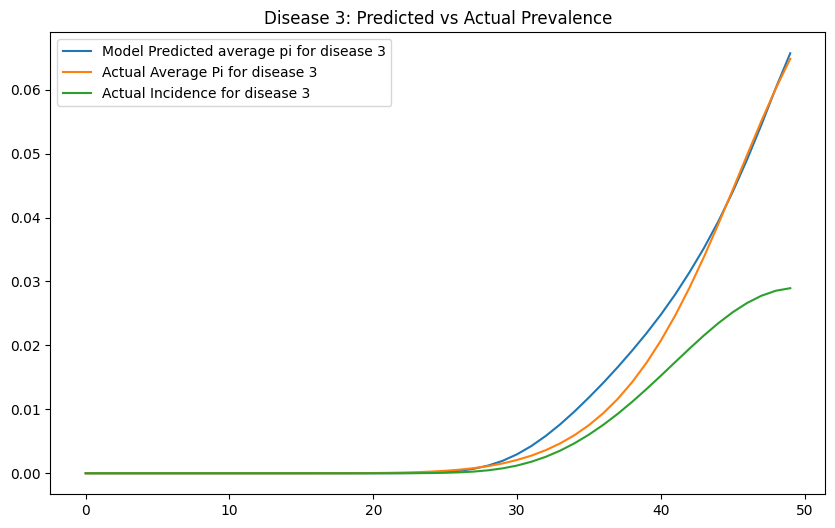

In [30]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[:, 3, :].mean(axis=0)  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted average pi for disease 3')
plt.plot(real_prev_pi, label='Actual Average Pi for disease 3 ')
plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

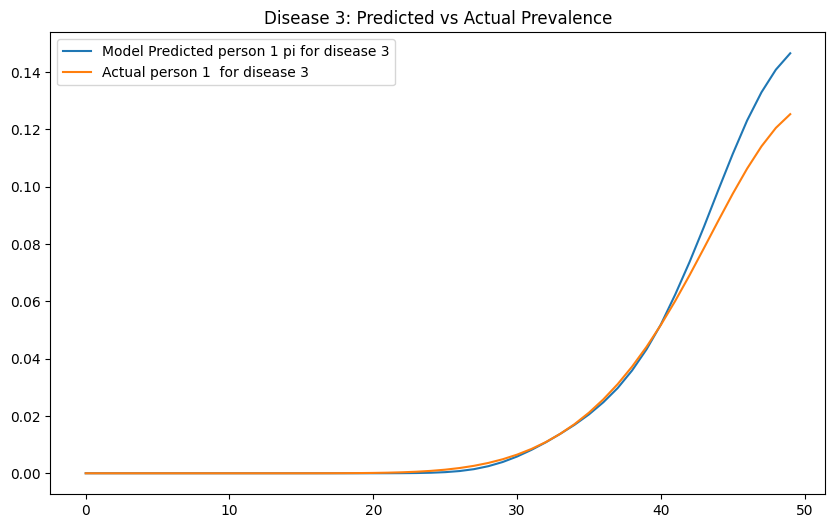

In [31]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[1, 3, :]  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][1,3, :]  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted person 1 pi for disease 3')
plt.plot(real_prev_pi, label='Actual person 1  for disease 3 ')
#plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

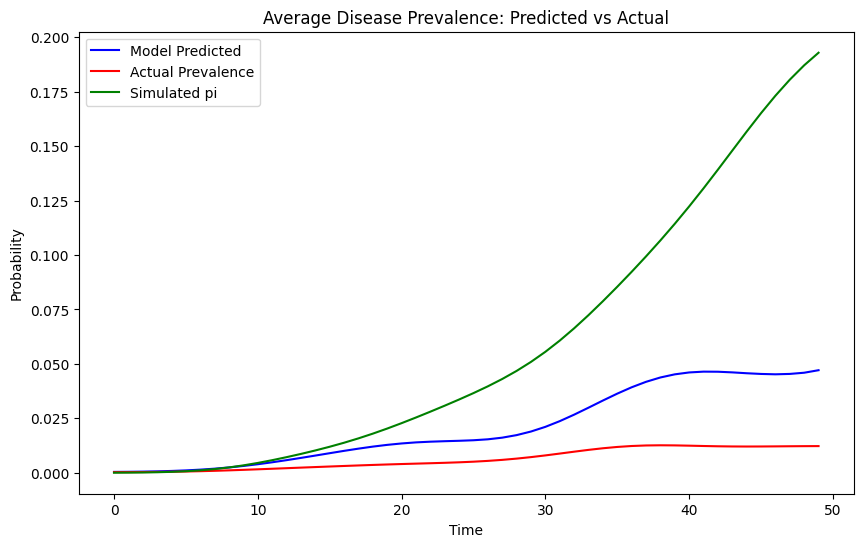

In [32]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
real_pi_all = data['pi'].mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [33]:
model.kappa

Parameter containing:
tensor([4.1958], requires_grad=True)

In [34]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()
#observed_risk=mu_dt_flat
# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor
print(scale_factor)
print(np.mean(observed_risk))
print(np.mean(predicted_risk)) 
print(np.mean(calibrated_risk))

0.39541543
0.0083208
0.021043185
0.0083208


In [35]:
calibrated_risk.shape

(1000,)

In [36]:
scale_factor

np.float32(0.39541543)

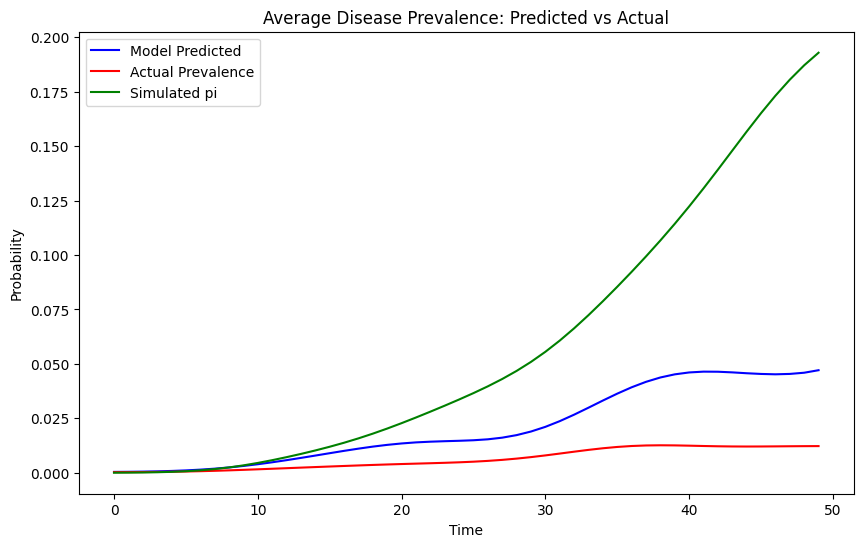

In [37]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))
#mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
#real_pi_all = calibrated_risk.mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

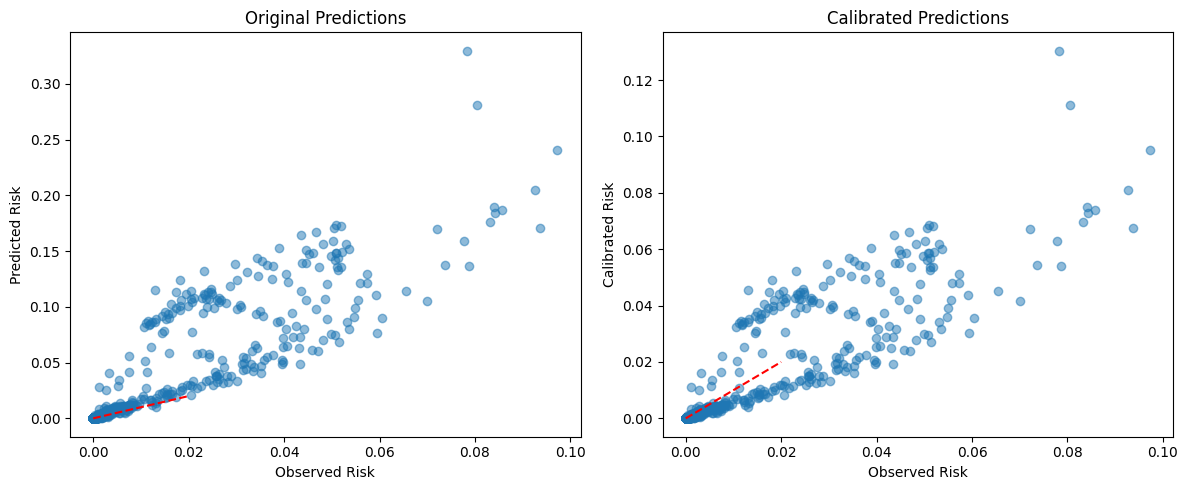

Mean observed risk: 0.008321
Mean predicted risk (original): 0.021043
Mean predicted risk (calibrated): 0.008321
Calibration scale factor: 0.395


In [38]:

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [39]:
def plot_hazard_comparison(Y, pi_pred, true_pi, calibration_factor):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Apply calibration to predictions
    calibrated_pred = pi_pred * calibration_factor
    
    # Calculate means for at-risk only
    mean_pred = []
    mean_true = []
    mean_obs = []
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            mean_pred.append(calibrated_pred[:,:,t][mask_t].mean())
            mean_true.append(true_pi[:,:,t][mask_t].mean())
            mean_obs.append(Y[:,:,t][mask_t].mean())
    
    plt.figure(figsize=(12,8))
    plt.plot(mean_pred, 'b-', label='Calibrated Model Prediction')
    plt.plot(mean_true, 'g--', label='True Hazard')
    plt.plot(mean_obs, 'r.', label='Observed Events')
    plt.title('Hazard Rates (At-Risk Individuals)')
    plt.xlabel('Time')
    plt.ylabel('Hazard')
    plt.legend()
    plt.show()

In [40]:
def calculate_calibration_factor(Y, pi_pred, true_pi):
    """
    Calculate calibration factor comparing predictions to true hazards
    Only using at-risk times
    """
    # Create at_risk mask
    N, D, T = Y.shape
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Get valid predictions and true values
    valid_pred = pi_pred[at_risk]
    valid_true = true_pi[at_risk]
    
    # Calculate calibration factor
    calibration_factor = valid_true.mean() / valid_pred.mean()
    
    print(f"Mean predicted: {valid_pred.mean():.6f}")
    print(f"Mean true: {valid_true.mean():.6f}")
    print(f"Calibration factor: {calibration_factor:.4f}")
    
    return calibration_factor

In [43]:
calculate_calibration_factor(Y, pi_pred, data['pi'])

Mean predicted: 0.009409
Mean true: 0.009513
Calibration factor: 1.0111


np.float64(1.0110507150209007)

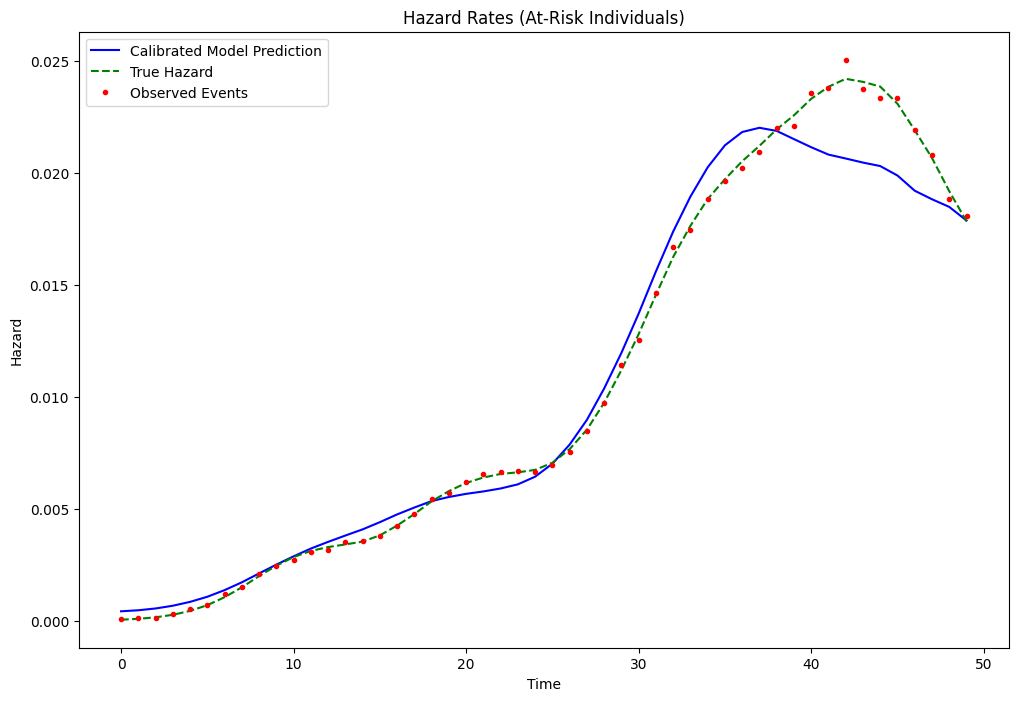

In [44]:
plot_hazard_comparison(data['Y'], pi_pred, data['pi'],1)

In [45]:
def calculate_fair_calibration_factor(Y, pi_pred):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Calculate ratio of observed events to predictions for at-risk individuals
    total_observed = 0
    total_predicted = 0
    
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            total_observed += Y[:,:,t][mask_t].sum()
            total_predicted += pi_pred[:,:,t][mask_t].sum()
    
    return total_observed / total_predicted if total_predicted > 0 else 1.0

cf=calculate_fair_calibration_factor(Y, pi_pred)

In [48]:
cf

np.float32(1.0107169)

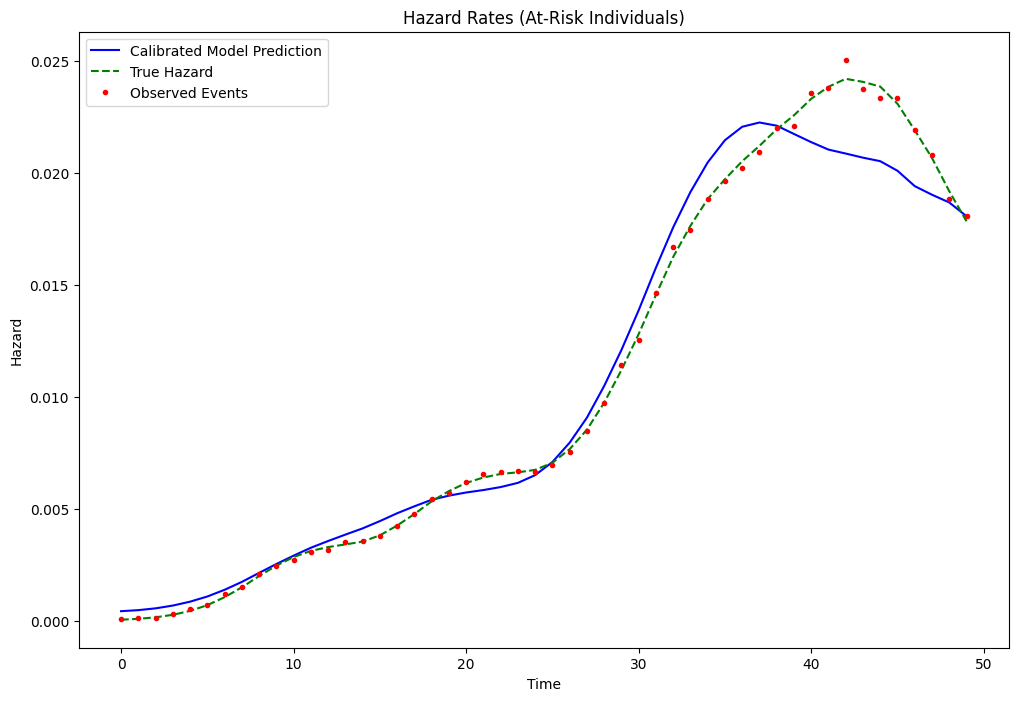

In [47]:
def plot_hazard_comparison(Y, pi_pred, true_pi, calibration_factor):
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = False
    
    # Apply calibration to predictions
    calibrated_pred = pi_pred * calibration_factor

    # Calculate means for at-risk only
    mean_pred = []
    mean_true = []
    mean_obs = []
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            mean_pred.append(calibrated_pred[:,:,t][mask_t].mean())
            mean_true.append(true_pi[:,:,t][mask_t].mean())
            mean_obs.append(Y[:,:,t][mask_t].mean())
    
    plt.figure(figsize=(12,8))
    plt.plot(mean_pred, 'b-', label='Calibrated Model Prediction')
    plt.plot(mean_true, 'g--', label='True Hazard')
    #plt.plot(real_incidence_all, 'r-', label='Actual Observed Incidence') 
    plt.plot(mean_obs, 'r.', label='Observed Events')
    plt.title('Hazard Rates (At-Risk Individuals)')
    plt.xlabel('Time')
    plt.ylabel('Hazard')
    plt.legend()
    
    plt.savefig('hazard_rates_kappa1.pdf', bbox_inches='tight', dpi=300)
    plt.show()
plot_hazard_comparison(Y, pi_pred, data['pi'],cf )


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_discrimination_metrics(y_true, y_pred, title_prefix="Model"):
    """
    Create comprehensive discrimination plots for binary outcomes
    
    Args:
        y_true: True binary labels
        y_pred: Predicted probabilities
        title_prefix: Prefix for plot titles
    """
    # Flatten arrays if multi-dimensional
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Remove any NaN values
    valid_indices = ~np.isnan(y_true_flat) & ~np.isnan(y_pred_flat)
    y_true_flat = y_true_flat[valid_indices]
    y_pred_flat = y_pred_flat[valid_indices]
    
    # Create figure with multiple plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
    roc_auc = auc(fpr, tpr)
    
    axes[0, 0].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    axes[0, 0].plot([0, 1], [0, 1], 'k--')
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title(f'{title_prefix} ROC Curve')
    axes[0, 0].legend(loc='lower right')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)
    avg_precision = average_precision_score(y_true_flat, y_pred_flat)
    
    axes[0, 1].plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title(f'{title_prefix} Precision-Recall Curve')
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Discrimination Slope (Boxplot of predictions by outcome)
    axes[1, 0].boxplot([y_pred_flat[y_true_flat==0], y_pred_flat[y_true_flat==1]], 
                      labels=['No Disease', 'Disease'])
    axes[1, 0].set_ylabel('Predicted Probability')
    axes[1, 0].set_title(f'{title_prefix} Discrimination Slope')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Calculate discrimination slope
    mean_pos = np.mean(y_pred_flat[y_true_flat==1])
    mean_neg = np.mean(y_pred_flat[y_true_flat==0])
    disc_slope = mean_pos - mean_neg
    axes[1, 0].text(0.05, 0.95, f'Discrimination Slope = {disc_slope:.3f}', 
                   transform=axes[1, 0].transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
    
    # 4. Calibration Plot (Predicted vs Observed)
    # Create 10 bins of predicted probabilities
    n_bins = 10
    bins = np.linspace(0, 1, n_bins+1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_indices = np.digitize(y_pred_flat, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins-1)  # Ensure within bounds
    
    bin_observed = np.array([np.mean(y_true_flat[bin_indices == i]) if np.sum(bin_indices == i) > 0 else np.nan 
                            for i in range(n_bins)])
    bin_predicted = np.array([np.mean(y_pred_flat[bin_indices == i]) if np.sum(bin_indices == i) > 0 else np.nan 
                             for i in range(n_bins)])
    bin_counts = np.array([np.sum(bin_indices == i) for i in range(n_bins)])
    
    # Remove bins with no data
    valid_bins = ~np.isnan(bin_observed) & ~np.isnan(bin_predicted)
    
    # Plot calibration
    axes[1, 1].scatter(bin_predicted[valid_bins], bin_observed[valid_bins], 
                      s=bin_counts[valid_bins]/np.max(bin_counts)*100, alpha=0.7)
    axes[1, 1].plot([0, 1], [0, 1], 'k--')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Observed Proportion')
    axes[1, 1].set_title(f'{title_prefix} Calibration Plot')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'auc': roc_auc,
        'avg_precision': avg_precision,
        'discrimination_slope': disc_slope
    }

# Usage with your simulated data:
# Assuming you have:
# - data['Y'] = actual outcomes
# - pi_pred = model predictions
# - data['pi'] = simulated pi values

# 1. Plot discrimination for your model predictions
model_metrics = plot_discrimination_metrics(data['Y'], pi_pred, "Model Predictions")

# 2. Plot discrimination for the simulated pi values
simulated_metrics = plot_discrimination_metrics(data['Y'], data['pi'], "Simulated π")

# 3. Compare metrics
metrics_comparison = pd.DataFrame({
    'Model': [model_metrics['auc'], model_metrics['avg_precision'], model_metrics['discrimination_slope']],
    'Simulated': [simulated_metrics['auc'], simulated_metrics['avg_precision'], simulated_metrics['discrimination_slope']]
}, index=['AUC', 'Average Precision', 'Discrimination Slope'])

print("Discrimination Metrics Comparison:")
print(metrics_comparison)

# 4. Time-specific discrimination (optional)
# For specific time points (e.g., t=30)
t = 30
time_metrics = plot_discrimination_metrics(data['Y'][:,:,t], pi_pred[:,:,t], f"Age {t+30} Predictions")

In [ ]:
plot_best_matches(data['pi'], model.forward()[0],n_samples=6)


In [ ]:
def get_at_risk_hazards(Y, pi_pred):
    """
    Get hazards only for individuals still at risk
    
    Args:
        Y: N x D x T array of events
        pi_pred: N x D x T array of predicted hazards
    """
    N, D, T = Y.shape
    
    # Create at_risk mask (1 if no event has occurred yet)
    at_risk = np.ones_like(Y)
    for n in range(N):
        for d in range(D):
            # Find first event
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                first_event = event_times[0]
                # Mask out all times after first event
                at_risk[n,d,(first_event+1):] = 0
    
    # Get mean hazards for at-risk individuals
    valid_hazards = pi_pred[at_risk == 1]
    true_events = Y[at_risk == 1]
    
    return valid_hazards, true_events

# Calculate hazards
valid_hazards, true_events = get_at_risk_hazards(Y, pi_pred)

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(valid_hazards.mean(axis=0), 'b-', label='Model Predicted Hazard (At Risk)')
plt.plot(true_events.mean(axis=0), 'r-', label='Observed Event Rate (At Risk)')
plt.title('Hazard Rates for At-Risk Individuals')
plt.xlabel('Time')
plt.ylabel('Hazard')
plt.legend()
plt.show()

# Calculate calibration
from sklearn.calibration import calibration_curve
y_true = true_events.flatten()
y_pred = valid_hazards.flatten()
prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)

plt.figure(figsize=(8,8))
plt.plot(prob_pred, prob_true, 'bo-')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Proportion')
plt.title('Calibration Plot (At-Risk Only)')
plt.show()


get_at_risk_hazards(data['Y'], pi_pred)

In [ ]:
calibration_factor

In [ ]:
def plot_hazard_comparisons(Y, pi_pred, true_pi, calibration_factor):
    """
    Compare hazards for at-risk individuals
    """
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                # Use event_times[0] for first event
                at_risk[n,d,(event_times[0]+1):] = 0
    
    # Get calibrated predictions and true hazards for at-risk only
    calibrated_pred = pi_pred * calibration_factor
    calibrated_at_risk = calibrated_pred[at_risk == 1]
    true_hazard_at_risk = true_pi[at_risk == 1]
    observed_rate = Y[at_risk == 1]
    
    plt.figure(figsize=(10,6))
    plt.plot(calibrated_at_risk.mean(axis=0), 'b-', label='Calibrated Model Prediction')
    plt.plot(true_hazard_at_risk.mean(axis=0), 'g-', label='True Hazard')
    plt.plot(observed_rate.mean(axis=0), 'r-', label='Observed Events')
    plt.title('Hazard Rates for At-Risk Individuals')
    plt.xlabel('Time')
    plt.ylabel('Hazard')
    plt.legend()
    plt.show()


plot_hazard_comparisons(data['Y'], pi_pred, data['pi'], scale_factor)

In [167]:
def plot_hazard_comparisons(Y, pi_pred, true_pi, calibration_factor):
    """
    Compare hazards for at-risk individuals
    """
    N, D, T = Y.shape
    
    # Create at_risk mask
    at_risk = np.ones_like(Y)
    for n in range(N):
        for d in range(D):
            event_times = np.where(Y[n,d,:])[0]
            if len(event_times) > 0:
                at_risk[n,d,(event_times[0]+1):] = 0
    
    # Get calibrated predictions and true hazards for at-risk only
    calibrated_pred = pi_pred * calibration_factor
    
    # Calculate means over time (only for at-risk)
    mean_pred = []
    mean_true = []
    mean_obs = []
    
    for t in range(T):
        at_risk_t = at_risk[:,:,t]
        if at_risk_t.sum() > 0:
            mean_pred.append(calibrated_pred[:,:,t][at_risk_t].mean())
            mean_true.append(true_pi[:,:,t][at_risk_t].mean())
            mean_obs.append(Y[:,:,t][at_risk_t].mean())
    
    plt.figure(figsize=(12,8))
    time_points = np.arange(len(mean_pred))
    plt.plot(time_points, mean_pred, 'b-', linewidth=2, label='Model Prediction (Calibrated)')
    plt.plot(time_points, mean_true, 'g--', alpha=0.7, label='True Hazard')
    plt.plot(time_points, mean_obs, 'r.', alpha=0.5, label='Observed Events')
    
    plt.title('Hazard Rates Over Time (At-Risk Individuals)', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Hazard', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_hazard_comparisons(data['Y'], pi_pred, data['pi'], scale_factor)

In [ ]:

# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(data['Y'])  # Average over individuals

# Initialize model with synthetic data
model_est = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=data['G'],
    Y=data['Y'],              # Added Y_tensor
    prevalence_t=prevalence_t
)

# Initialize with newly estimated psi


model_est.visualize_initialization()


In [ ]:
history = model_est.fit(data['event_times'], num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)


In [ ]:
plot_best_matches(data['pi'], model_est.forward()[0],n_samples=6)


In [17]:
with torch.no_grad():
    pi_pred, theta, phi = model_est.forward()
    pi_pred = pi_pred.cpu().numpy()

In [ ]:
#Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model_est.prevalence_t.mean(axis=0)  # Average across diseases
real_pi_all = data['pi'].mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [54]:
def compare_cluster_recovery(true_psi, estimated_psi):
    """
    Visualize how well the estimated clusters match true clusters
    accounting for arbitrary cluster labeling
    """
    # Convert psi matrices to cluster assignments
    true_clusters = np.argmax(true_psi, axis=0)
    est_clusters = np.argmax(estimated_psi, axis=0)
    
    # Create confusion matrix
    K = true_psi.shape[0]
    confusion = np.zeros((K, K))
    for i in range(len(true_clusters)):
        confusion[true_clusters[i], est_clusters[i]] += 1
    
    # Plot
    plt.figure(figsize=(10, 5))
    
    # Original cluster assignments
    plt.subplot(121)
    sns.heatmap(true_psi, cmap='RdBu_r', center=0)
    plt.title('True Cluster Assignments')
    plt.xlabel('Disease')
    plt.ylabel('True Cluster')
    
    # Recovered cluster assignments
    plt.subplot(122)
    sns.heatmap(estimated_psi, cmap='RdBu_r', center=0)
    plt.title('Recovered Cluster Assignments')
    plt.xlabel('Disease')
    plt.ylabel('Recovered Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Print matching statistics
    print("\nCluster Matching Matrix:")
    print(confusion)
    
    # Calculate percentage of diseases correctly clustered together
    total_pairs = 0
    correct_pairs = 0
    for d1 in range(len(true_clusters)):
        for d2 in range(d1+1, len(true_clusters)):
            total_pairs += 1
            if (true_clusters[d1] == true_clusters[d2]) == (est_clusters[d1] == est_clusters[d2]):
                correct_pairs += 1
    
    print(f"\nPercentage of disease pairs correctly clustered together: {100*correct_pairs/total_pairs:.1f}%")

# Use with:

np.random.seed(42)
data = generate_clustered_survival_data(N=10000, D=20, T=50, K=5, P=5)
true_psi=data['psi']


In [ ]:
type(model_est.psi.detach().numpy())

In [ ]:

#psi_est=model_est.psi.detach().numpy()
compare_cluster_recovery(true_psi,model_est.psi.detach().numpy())

In [ ]:
import pandas as pd
def verify_marginal_probabilities(Y, pi_pred, age_start=10, age_window=10):
    """
    Compare predicted marginal probabilities with observed rates
    """
    N, D, T = Y.shape
    verification = []
    
    for d in range(D):
        # Get people at risk
        at_risk = ~np.any(Y[:, d, :age_start], axis=1)
        n_at_risk = np.sum(at_risk)
        
        if n_at_risk >= 100:  # Minimum sample size
            # Predicted probability
            yearly_pi = pi_pred[at_risk, d, age_start:age_start+age_window]
            pred_risk = 1 - np.prod(1 - yearly_pi, axis=1).mean()
            
            # Observed probability
            observed = np.any(Y[at_risk, d, age_start:age_start+age_window], axis=1).mean()
            
            verification.append({
                #'disease': disease_name_list[d],
                'predicted_risk': pred_risk,
                'observed_risk': observed,
                'ratio_pred_obs': pred_risk/observed if observed > 0 else np.nan,
                'n_at_risk': n_at_risk,
                'n_events': np.sum(np.any(Y[at_risk, d, age_start:age_start+age_window], axis=1))
            })
    
    verify_df = pd.DataFrame(verification)
    
    # Sort by absolute difference between predicted and observed
    verify_df['abs_diff'] = np.abs(verify_df.predicted_risk - verify_df.observed_risk)
    verify_df = verify_df.sort_values('abs_diff', ascending=False)
    
    print("\nTop 10 largest discrepancies between predicted and observed risks:")
    print(verify_df.head(10)[['predicted_risk', 'observed_risk', 'ratio_pred_obs', 'n_events', 'n_at_risk']])
    
    print("\nSummary statistics of prediction/observation ratios:")
    print(verify_df.ratio_pred_obs.describe())
    
    # Plot predicted vs observed
    plt.figure(figsize=(10, 10))
    plt.scatter(verify_df.observed_risk, verify_df.predicted_risk, alpha=0.5)
    plt.plot([0, max(verify_df.observed_risk.max(), verify_df.predicted_risk.max())], 
             [0, max(verify_df.observed_risk.max(), verify_df.predicted_risk.max())], 
             'r--')
    plt.xlabel('Observed Risk')
    plt.ylabel('Predicted Risk')
    plt.title('Predicted vs Observed Marginal Risks')
    plt.show()
    
    return verify_df
data['Y'].shape
with torch.no_grad():  
    pi_pred =model_est.forward()[0].cpu().numpy()
# Run verification
verify_df = verify_marginal_probabilities(Y=data['Y'],pi_pred=pi_pred)

In [ ]:
model.psi

In [ ]:
from cluster_g_logit_init import *
# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(data['Y'])  # Average over individuals

# Initialize model with synthetic data
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,              # Added Y_tensor
    prevalence_t=prevalence_t
)

# Initialize with true psi
#model.initialize_params(true_psi=true_psi)


model.visualize_initialization()


In [ ]:
history = model.fit(E_tensor, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)


In [ ]:
plot_best_matches(data['pi'], model.forward()[0],n_samples=6)


In [ ]:
def verify_marginal_probabilities(Y, pi_pred, age_start=10, age_window=10):
    """
    Compare predicted marginal probabilities with observed rates
    """
    N, D, T = Y.shape
    verification = []
    
    for d in range(D):
        # Get people at risk
        at_risk = ~np.any(Y[:, d, :age_start], axis=1)
        n_at_risk = np.sum(at_risk)
        
        if n_at_risk >= 100:  # Minimum sample size
            # Predicted probability
            yearly_pi = pi_pred[at_risk, d, age_start:age_start+age_window]
            pred_risk = 1 - np.prod(1 - yearly_pi, axis=1).mean()
            
            # Observed probability
            observed = np.any(Y[at_risk, d, age_start:age_start+age_window], axis=1).mean()
            
            verification.append({
                #'disease': disease_name_list[d],
                'predicted_risk': pred_risk,
                'observed_risk': observed,
                'ratio_pred_obs': pred_risk/observed if observed > 0 else np.nan,
                'n_at_risk': n_at_risk,
                'n_events': np.sum(np.any(Y[at_risk, d, age_start:age_start+age_window], axis=1))
            })
    
    verify_df = pd.DataFrame(verification)
    
    # Sort by absolute difference between predicted and observed
    verify_df['abs_diff'] = np.abs(verify_df.predicted_risk - verify_df.observed_risk)
    verify_df = verify_df.sort_values('abs_diff', ascending=False)
    
    print("\nTop 10 largest discrepancies between predicted and observed risks:")
    print(verify_df.head(10)[['predicted_risk', 'observed_risk', 'ratio_pred_obs', 'n_events', 'n_at_risk']])
    
    print("\nSummary statistics of prediction/observation ratios:")
    print(verify_df.ratio_pred_obs.describe())
    
    # Plot predicted vs observed
    plt.figure(figsize=(10, 10))
    plt.scatter(verify_df.observed_risk, verify_df.predicted_risk, alpha=0.5)
    plt.plot([0, max(verify_df.observed_risk.max(), verify_df.predicted_risk.max())], 
             [0, max(verify_df.observed_risk.max(), verify_df.predicted_risk.max())], 
             'r--')
    plt.xlabel('Observed Risk')
    plt.ylabel('Predicted Risk')
    plt.title('Predicted vs Observed Marginal Risks')
    plt.show()
    
    return verify_df
data['Y'].shape
with torch.no_grad():  
    pi_pred =model.forward()[0].cpu().numpy()
# Run verification
verify_df = verify_marginal_probabilities(Y=data['Y'],pi_pred=pi_pred)

In [ ]:
model.lambda_

In [ ]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
real_pi_all = data['pi'].mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:
def visualize_predictions(model, Y, event_times):
    with torch.no_grad():
        pi_pred, _, _ = model.forward()
        pi_pred = pi_pred.cpu().numpy()
    
    N, D, T = Y.shape
    at_risk = np.zeros_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            at_risk[n,d,:event_times[n,d]] = True
    
    # Get predictions
    event_probs = pi_pred[Y == 1 & at_risk]
    nonevent_probs = pi_pred[Y == 0 & at_risk]
    
    plt.figure(figsize=(15, 5))
    
    # 1. Density plot of predictions
    plt.subplot(131)
    plt.hist(event_probs, bins=50, density=True, alpha=0.5, label='Events', color='red')
    plt.hist(nonevent_probs, bins=50, density=True, alpha=0.5, label='Non-events', color='blue')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Distribution of Predictions')
    plt.legend()
    
    # 2. ROC curve
    from sklearn.metrics import roc_curve, auc
    y_true = np.concatenate([np.ones_like(event_probs), np.zeros_like(nonevent_probs)])
    y_pred = np.concatenate([event_probs, nonevent_probs])
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(132)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # 3. Calibration plot
    from sklearn.calibration import calibration_curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    
    plt.subplot(133)
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Empirical probability')
    plt.title('Calibration Plot')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Average pi for events: {event_probs.mean():.4f} (std: {event_probs.std():.4f})")
    print(f"Average pi for non-events: {nonevent_probs.mean():.4f} (std: {nonevent_probs.std():.4f})")
    print(f"AUC: {roc_auc:.4f}")
    
    return event_probs, nonevent_probs, roc_auc

visualize_predictions(model, data['Y'], data['event_times'])

In [24]:
# Initialize original model

data = generate_clustered_survival_data(N=10000, D=20, T=50, K=5, P=5)

# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(data['Y'])  # Average over individuals


In [ ]:
N=10000
T=50
K=5
P=5
D=20
G=data['G']
Y=data['Y']
E=data['event_times']
model_orig = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=N, D=D, T=T, K=K, P=P, G=G, Y=Y, prevalence_t=prevalence_t
)
model_orig(psi_config=)


In [ ]:


from pyScripts.cluster_g_logit_init_acceptpsi_flatlam_healthtoo import *
# Initialize new model with equivalent parameters
model_new = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=N, D=D, T=T, K=K, P=P, G=G, Y=Y, 
    prevalence_t=prevalence_t,
    init_var_scaler=1,
    genetic_scale=1.0,
    signature_references=None,
    healthy_reference=None,
    flat_lambda=True
)


In [ ]:

# Compare initializations
def compare_initializations(model1, model2):
    print("Comparing model initializations:")
    
    # Compare psi values
    psi_diff = torch.abs(model1.psi - model2.psi).mean()
    print(f"\nPsi mean difference: {psi_diff:.6f}")
    
    # Compare lambda values
    lambda_diff = torch.abs(model1.lambda_ - model2.lambda_).mean()
    print(f"Lambda mean difference: {lambda_diff:.6f}")
    
    # Compare phi values
    phi_diff = torch.abs(model1.phi - model2.phi).mean()
    print(f"Phi mean difference: {phi_diff:.6f}")
    
    # Visualize distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot psi distributions
    axes[0].hist(model1.psi.detach().flatten(), alpha=0.5, label='Original')
    axes[0].hist(model2.psi.detach().flatten(), alpha=0.5, label='New')
    axes[0].set_title('Psi Distribution')
    axes[0].legend()
    
    # Plot lambda distributions
    axes[1].hist(model1.lambda_.detach().flatten(), alpha=0.5, label='Original')
    axes[1].hist(model2.lambda_.detach().flatten(), alpha=0.5, label='New')
    axes[1].set_title('Lambda Distribution')
    axes[1].legend()
    
    # Plot phi distributions
    axes[2].hist(model1.phi.detach().flatten(), alpha=0.5, label='Original')
    axes[2].hist(model2.phi.detach().flatten(), alpha=0.5, label='New')
    axes[2].set_title('Phi Distribution')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

# Run comparison
compare_initializations(model_orig, model_new)

# Also compare cluster assignments
print("\nComparing cluster assignments:")
print("Original model clusters:", np.unique(model_orig.clusters, return_counts=True)[1])
print("New model clusters:", np.unique(model_new.clusters, return_counts=True)[1])

In [ ]:
model_new.visualize_initialization()

In [ ]:
model_orig.visualize_initialization()